# PPProjecct

In [ ]:
!pip install probaforms

## Data

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('train_cache.csv')
train.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
3,711226,387053.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
4,710919,387191.78,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [6]:
test = pd.read_csv('test_cache.csv')
test.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,21483,613944.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
1,21354,610190.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
2,20883,613910.75,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
3,21493,610052.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
4,21473,606866.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065


In [7]:
pd.unique(train[['block_size']]. values.ravel())

array([  8,  16,  32,  64, 256,   4, 128])

In [8]:
pd.unique(train[['n_jobs']]. values.ravel()).size

32

In [9]:
pd.unique(train[['iodepth']]. values.ravel()).size

16

In [10]:
pd.unique(train[['read_fraction']]. values.ravel()).size

101

In [11]:
pd.unique(train[['io_type']]. values.ravel())

array(['read', 'write'], dtype=object)

In [12]:
pd.unique(train[['id']]. values.ravel()).size

408

In [13]:
test['io_type_num'] = test['io_type'] == 'write'

In [14]:
test.io_type_num = test.io_type_num.replace({ True : 1 , False : 0 })

In [15]:
y_test = torch.tensor(test[['iops', 'lat']].values)

In [16]:
X_test = torch.tensor(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [17]:
train['io_type_num'] = train['io_type'] == 'write'

In [18]:
train.io_type_num = train.io_type_num.replace({ True : 1 , False : 0 })

In [19]:
y_tr = torch.tensor(train[['iops', 'lat']].values)

In [20]:
X_tr = torch.tensor(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Graphs

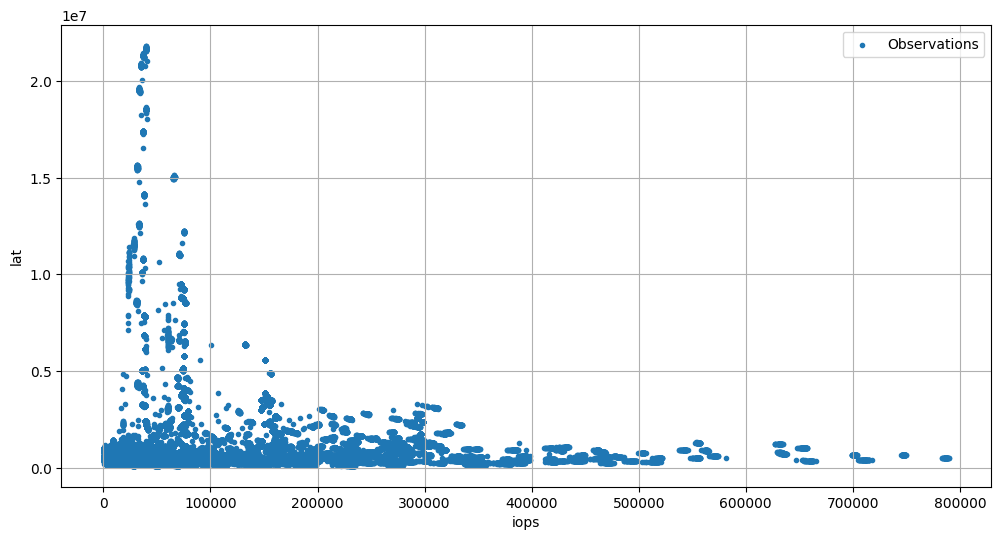

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr[:, 0], y_tr[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Scalers

In [22]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from dataclasses import dataclass

# from https://github.com/HEPML-AnomalyDetection/CATHODE/blob/4e96989296193da18508710afbfa3b37fffe5952/data_handler.py
def logit_transform_inverse(data, datamin, datamax):
    dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
    return dataout

def quick_logit(x, x_min, x_max, eps):
    x_norm = (x-x_min)/(x_max-x_min)
    x_norm = x_norm[((x_norm != 0) & (x_norm != 1)).all(axis=1)]
    x_norm[x_norm == 0] += eps
    x_norm[x_norm == 1] -= eps
    logit = np.log(x_norm/(1-x_norm))
    logit = logit[~np.isnan(logit).any(axis=1)]
    return logit

class LogitScaler(TransformerMixin, BaseEstimator):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None

    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0) - self.eps
        self.x_max = np.max(X, axis=0) + self.eps
        return self

    def transform(self, X):
        return quick_logit(X, self.x_min, self.x_max, self.eps)

    def inverse_transform(self, X):
        return logit_transform_inverse(X, self.x_min, self.x_max)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [24]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-22-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [25]:
stscaler = StandardScaler()

In [26]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Model

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_epochs=50)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

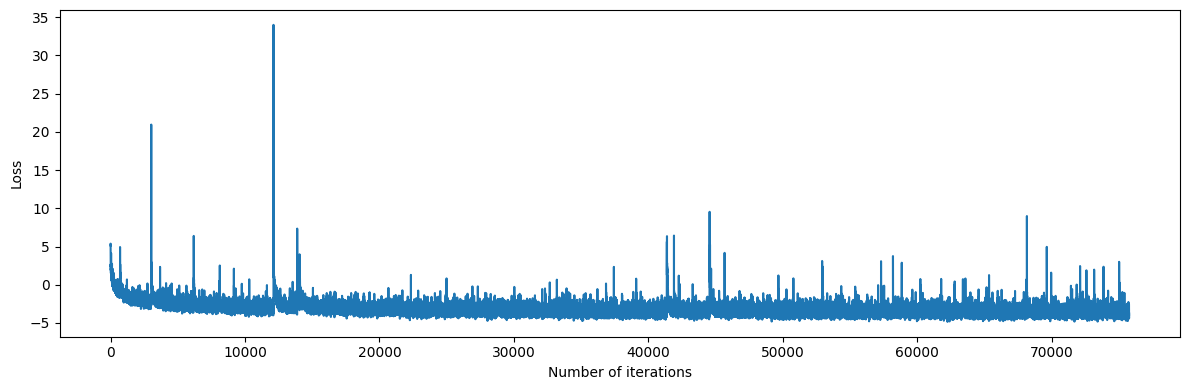

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[   20157.15989174,   603429.822886  ],
       [   23689.88493242,   658759.43064012],
       [   28839.69452382,   675432.59178954],
       ...,
       [   35724.59502757, 14306920.07522587],
       [   37629.22863344, 15071817.66816569],
       [   37586.38188704, 15062892.5456213 ]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

## Generated samples

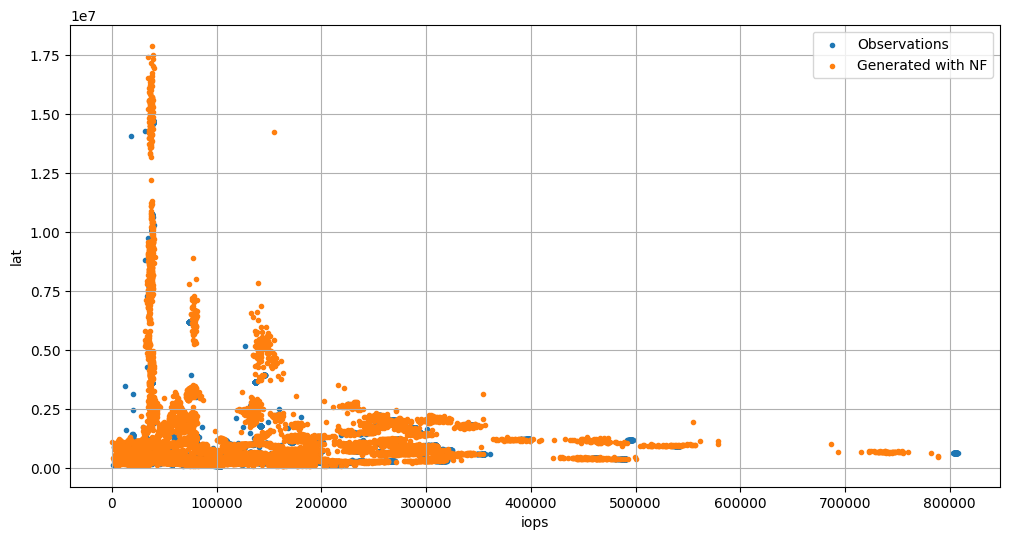

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

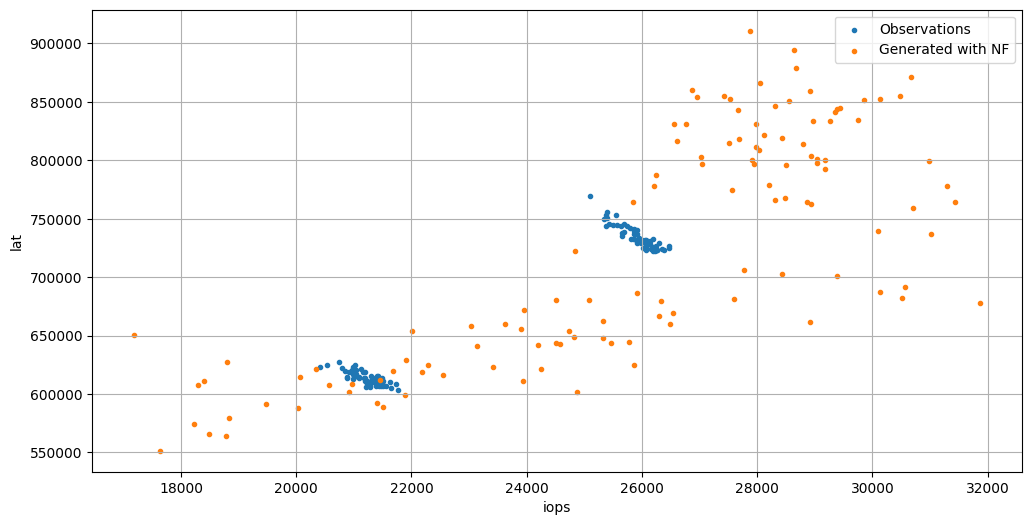

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

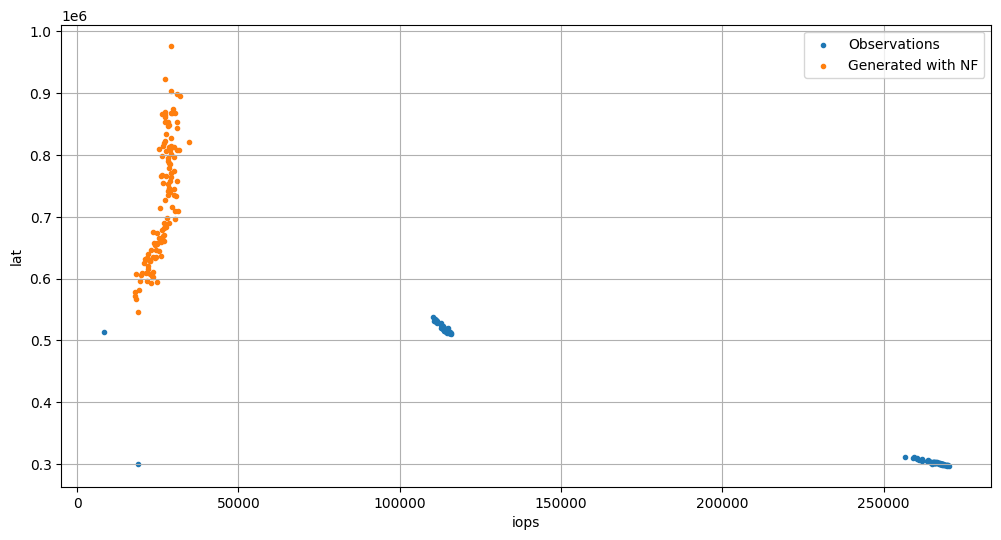

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Another model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-95-bb35ed73ac8a>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_epochs=100)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

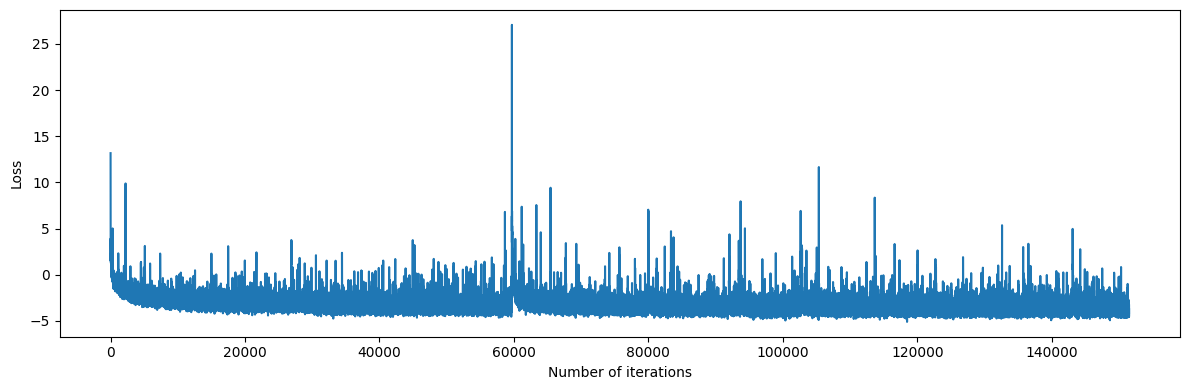

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[   17513.59434164,   553774.99399921],
       [   16686.16861124,   565539.99706364],
       [   21254.68888716,   568133.16164183],
       ...,
       [   39827.55564894, 13529266.42293231],
       [   38908.05216522, 14344408.67161573],
       [   38972.84451117, 14096112.2715898 ]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

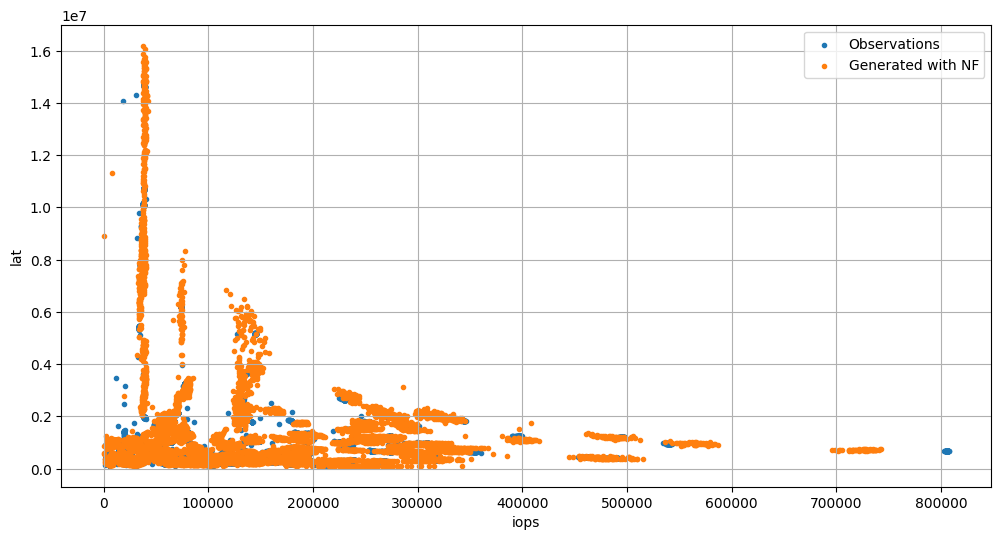

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

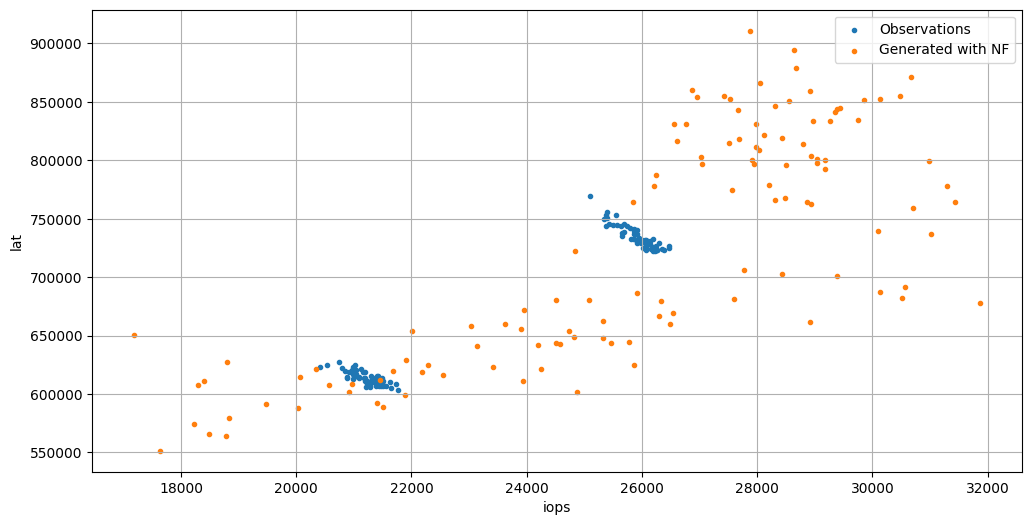

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

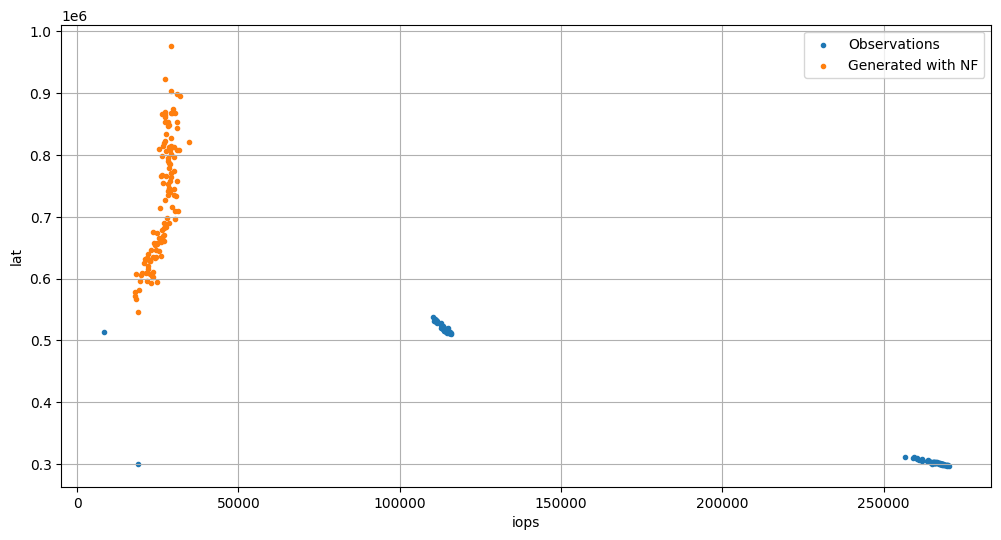

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 3rd model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-12-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.02, n_epochs=150)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

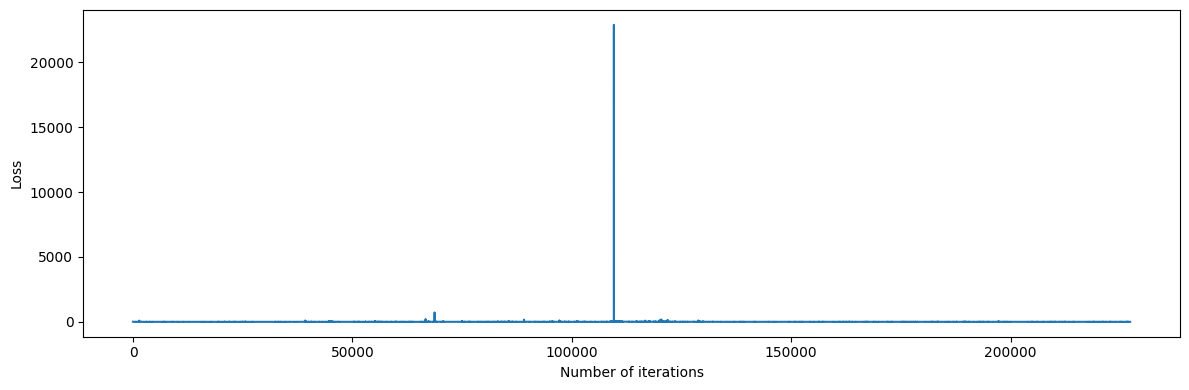

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[1.79270243e+04, 6.18833216e+05],
       [1.03055471e+04, 6.07866519e+05],
       [9.58715444e+03, 7.29707485e+05],
       ...,
       [5.48373413e+04, 1.98782009e+07],
       [4.20695632e+04, 1.74325719e+07],
       [6.36784268e+04, 1.12667596e+07]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

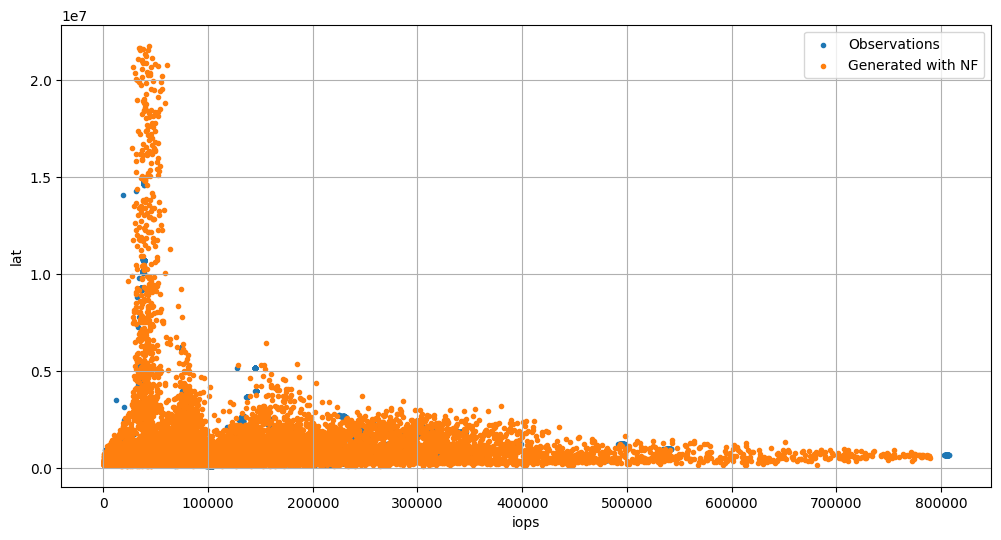

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

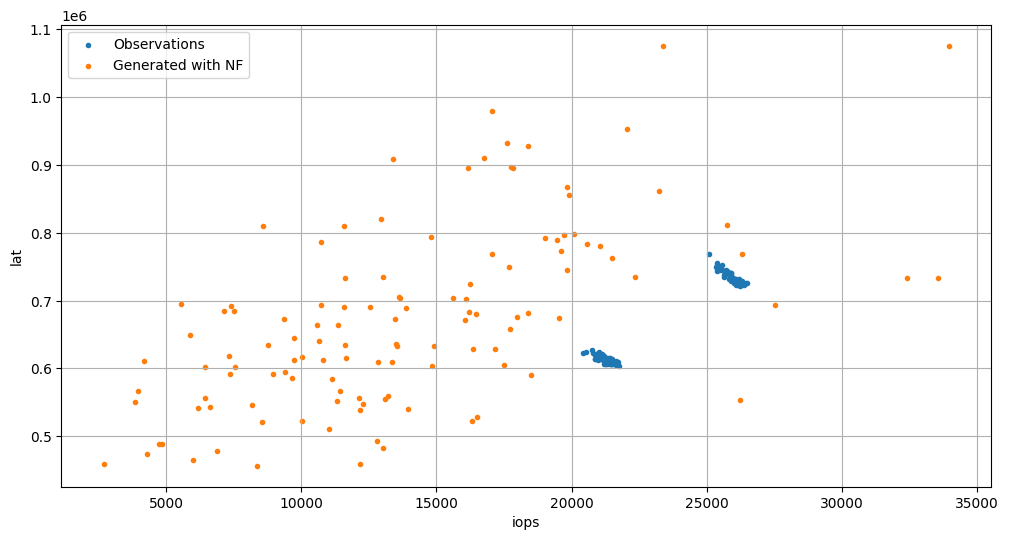

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

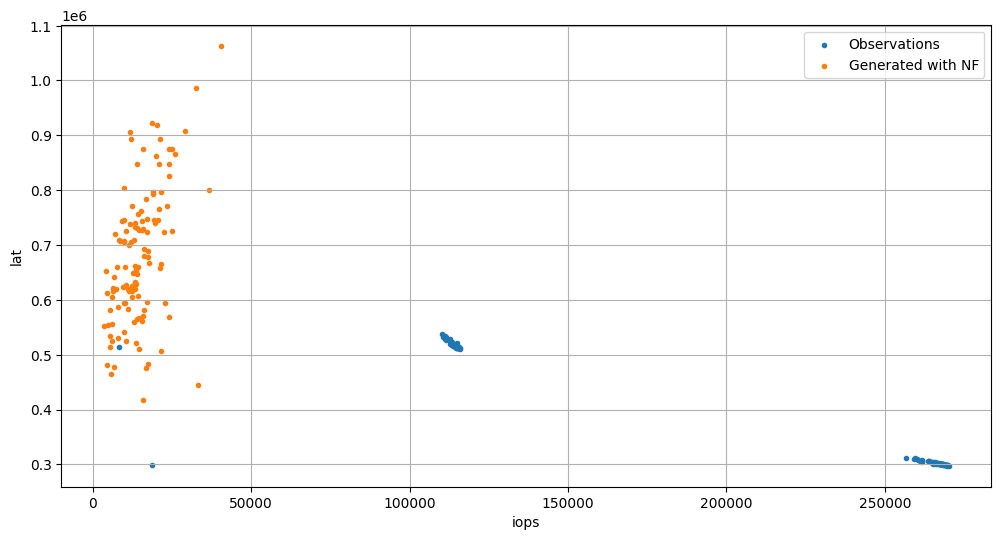

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

запустить на 300+ эпохах и lr поменять

## 4rd model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-19-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_layers=10, n_epochs=80, batch_size=64)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

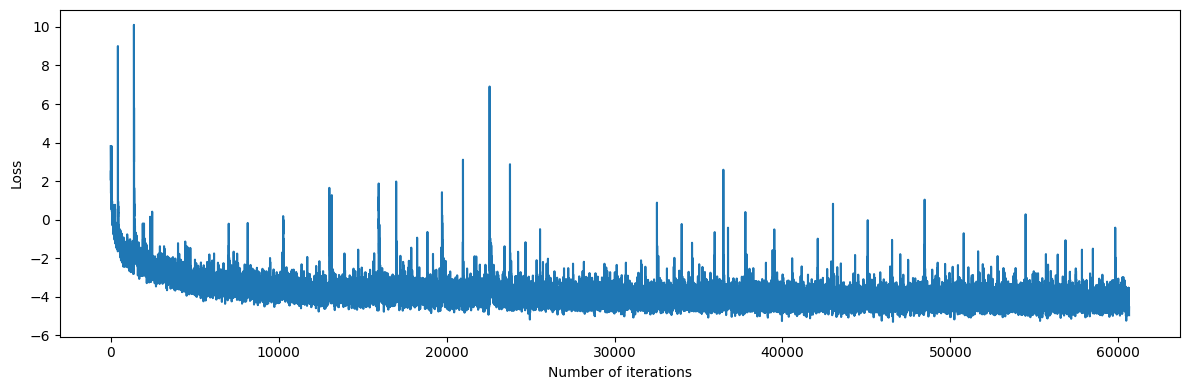

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[   19527.75988483,   622143.64739239],
       [   19652.5803788 ,   611572.28512742],
       [   19416.79192627,   620666.46587828],
       ...,
       [   37769.50684335, 15692450.25683066],
       [   37919.39484778, 14440014.34854124],
       [   38745.80427942, 14171927.72126031]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

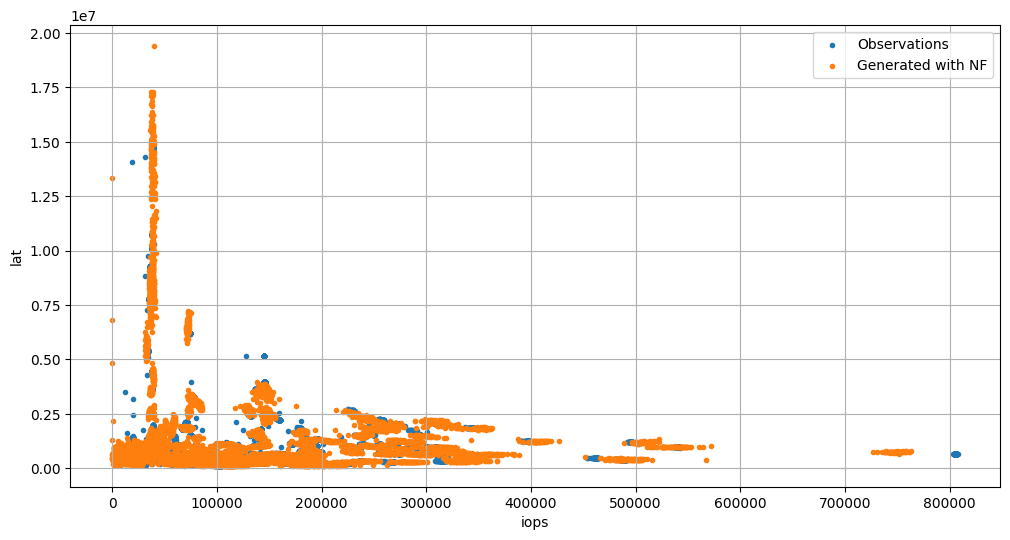

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

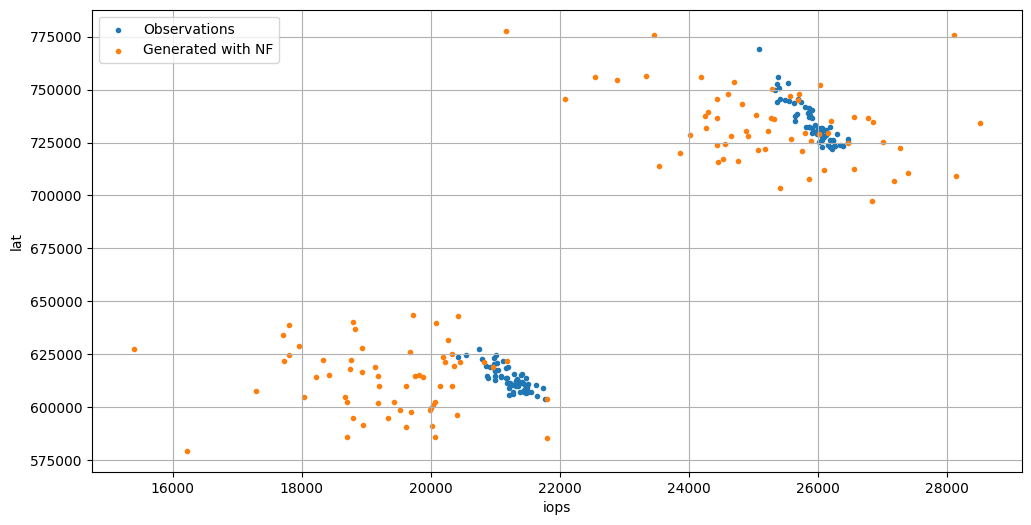

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

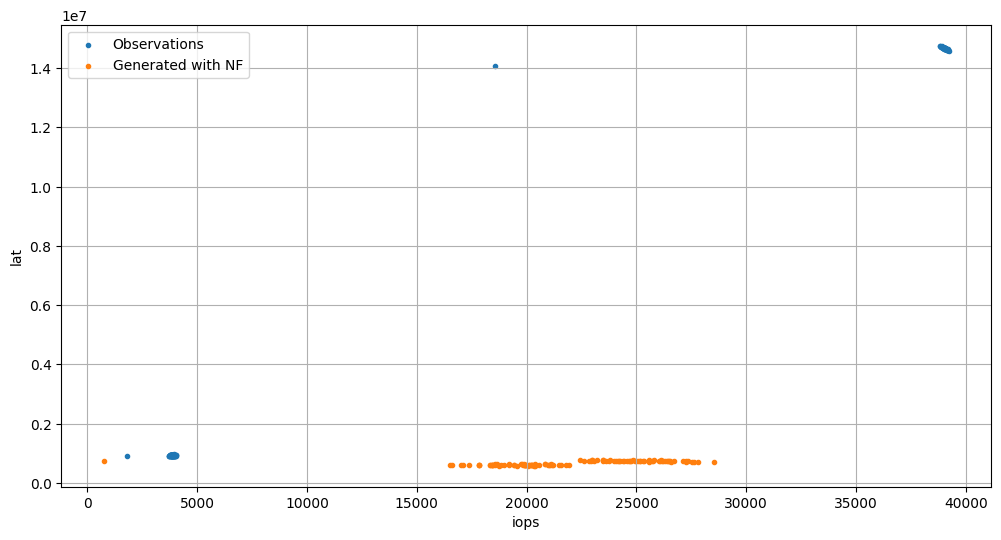

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 5th model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-19-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_layers=12, n_epochs=50, batch_size=64)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

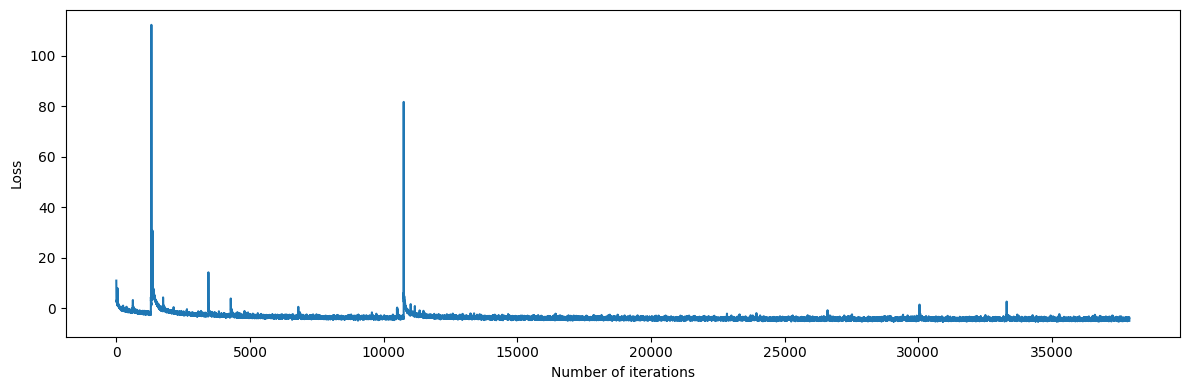

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

<ipython-input-19-a80eb4482932>:7: RuntimeWarning: overflow encountered in exp
  dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
<ipython-input-19-a80eb4482932>:7: RuntimeWarning: invalid value encountered in divide
  dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))


array([[   22484.83819572,   698638.31480431],
       [   22711.43003099,   687126.76222398],
       [   23660.66118456,   694310.87523849],
       ...,
       [   37790.102339  , 12725115.96992347],
       [   39038.40874228, 12089323.98767389],
       [   38589.5978038 , 14037669.41825824]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

<ipython-input-19-a80eb4482932>:7: RuntimeWarning: overflow encountered in exp
  dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
<ipython-input-19-a80eb4482932>:7: RuntimeWarning: invalid value encountered in divide
  dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))


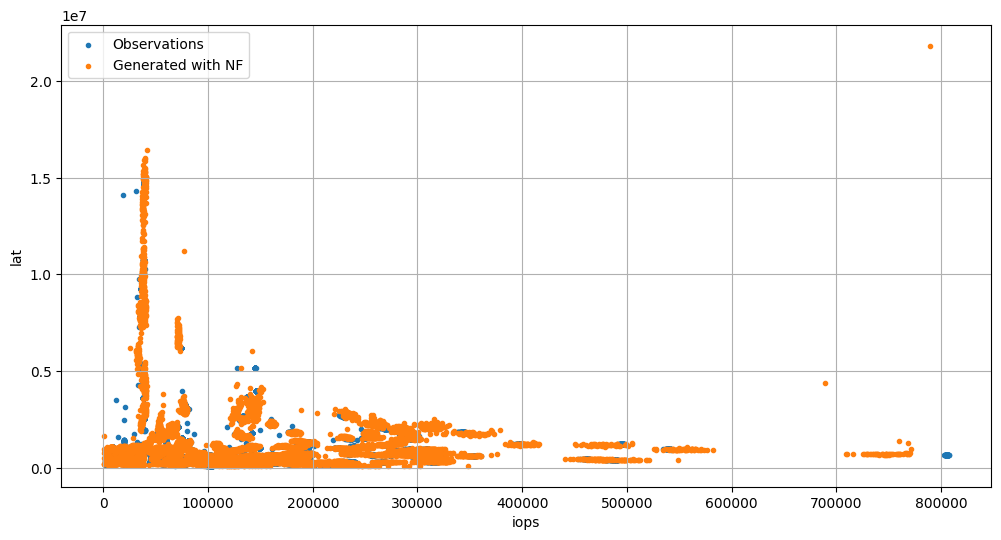

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

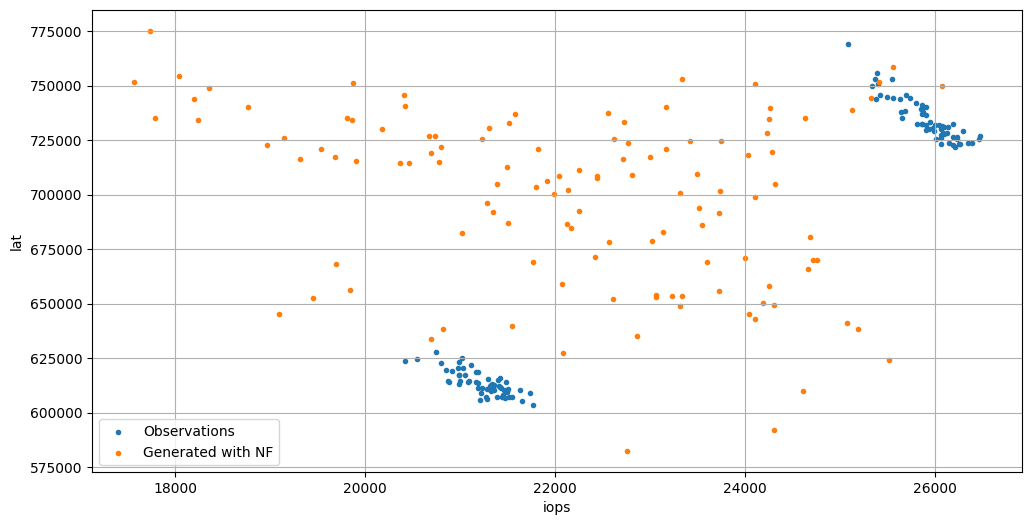

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

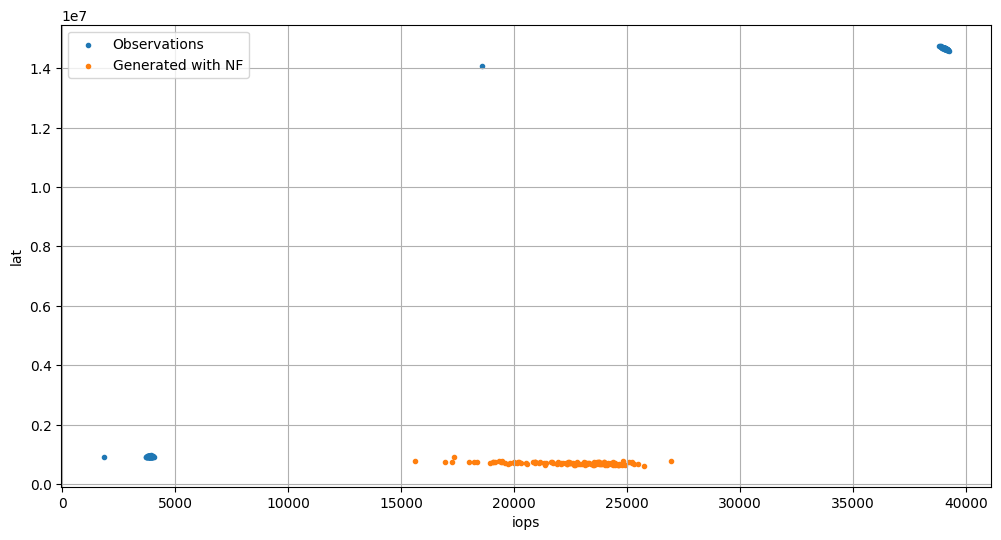

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 6th model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-19-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.005, n_layers=12, n_epochs=100, batch_size=64)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

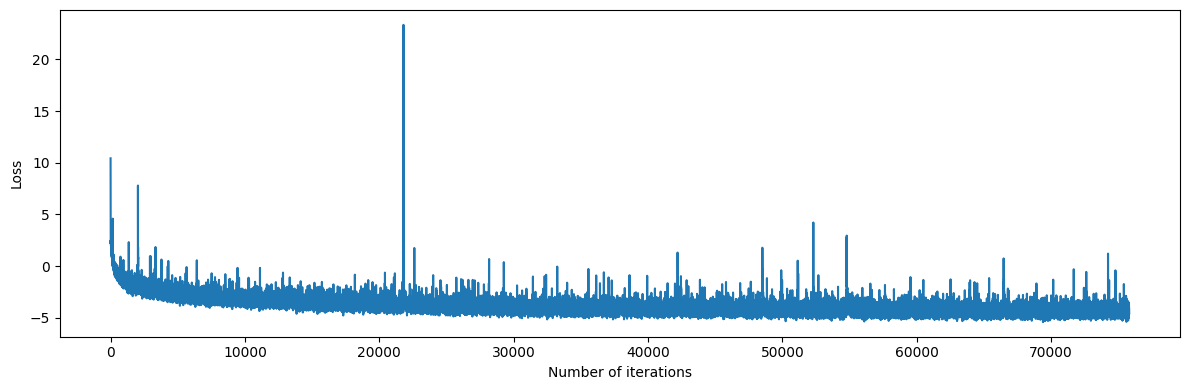

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[   18964.45658324,   601784.50497879],
       [   18731.36509177,   600318.76479019],
       [   18701.55245048,   615159.66069081],
       ...,
       [   38680.21577558, 17045305.75082603],
       [   38955.14919142, 16295718.78684009],
       [   41222.98805626, 14590172.54377376]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

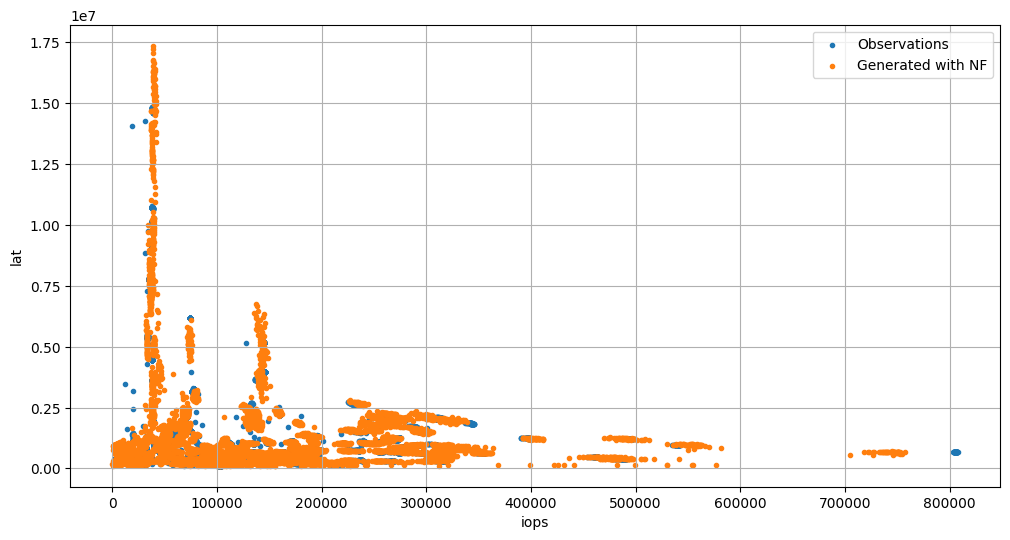

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

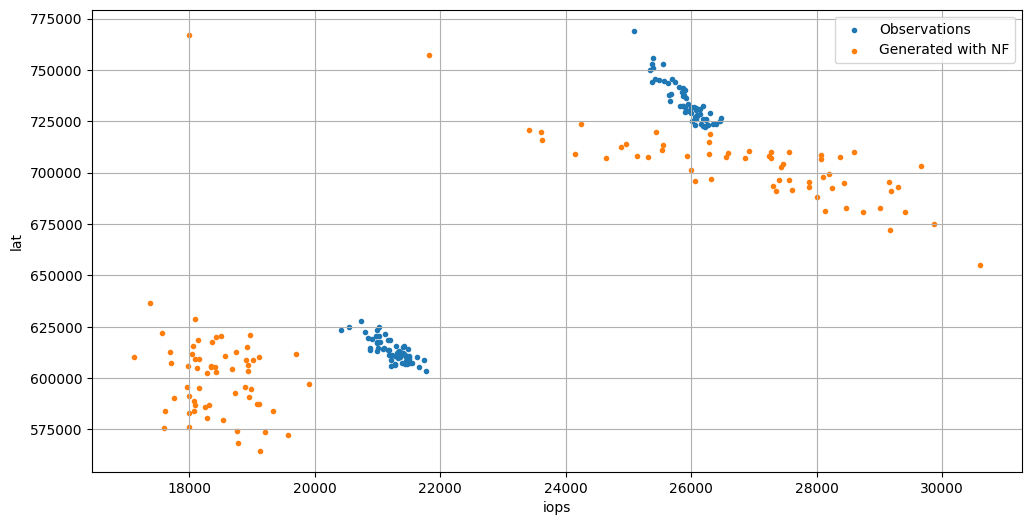

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

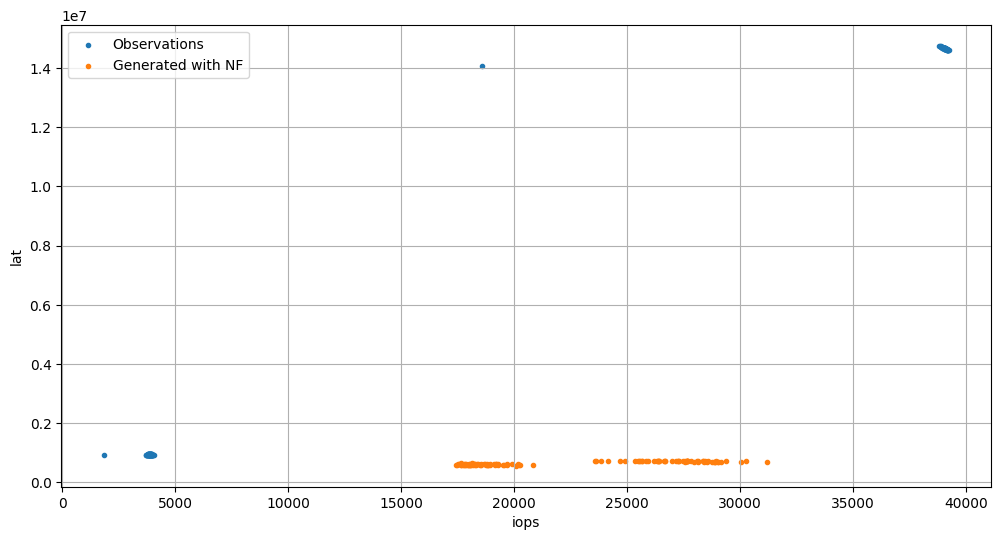

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 7th model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-19-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.005, n_layers=12, n_epochs=150, batch_size=64)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

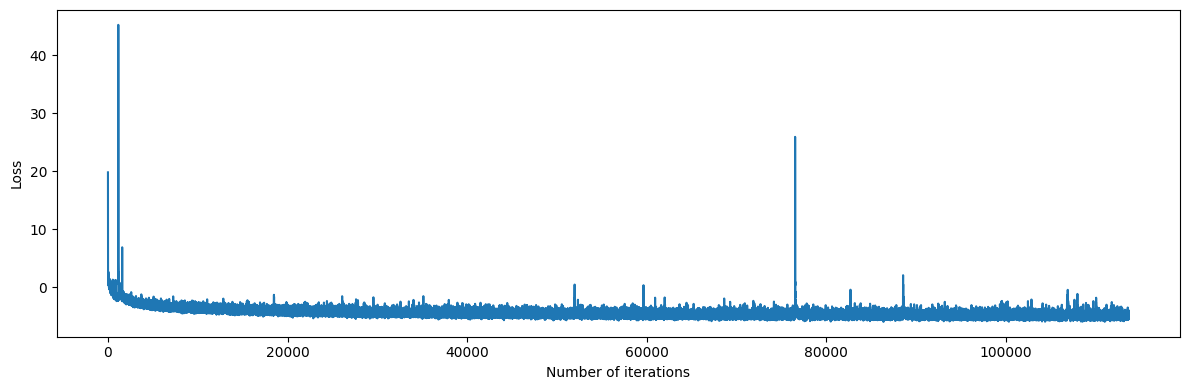

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[1.68297612e+04, 6.34474220e+05],
       [1.79621600e+04, 6.26852972e+05],
       [1.87133508e+04, 6.17588770e+05],
       ...,
       [3.59076471e+04, 1.88579800e+07],
       [3.56990776e+04, 1.88888818e+07],
       [3.59768947e+04, 1.41090741e+07]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

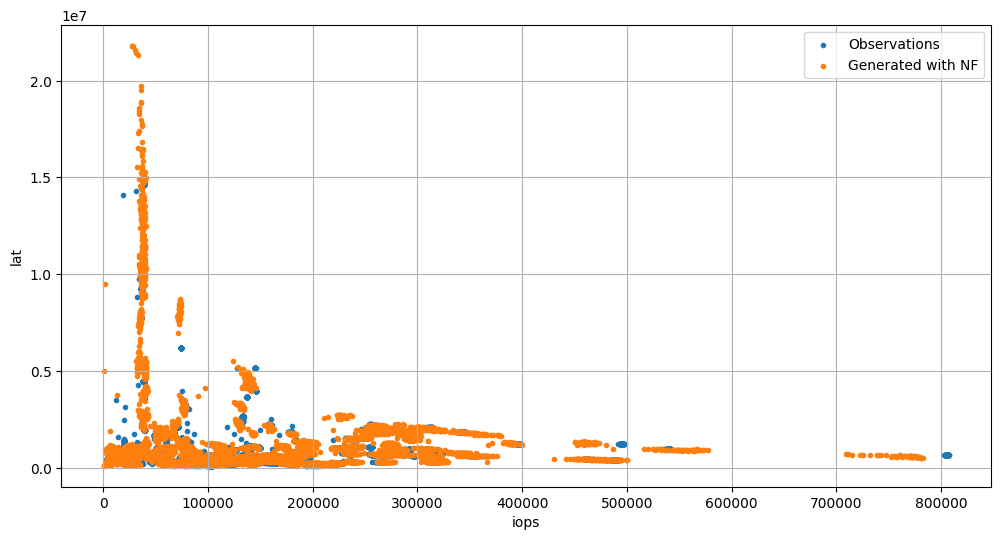

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

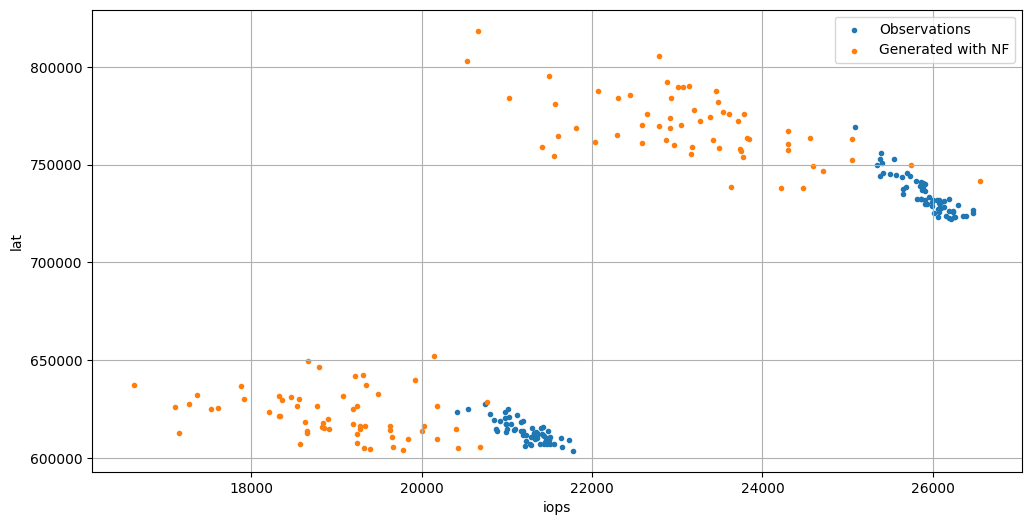

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

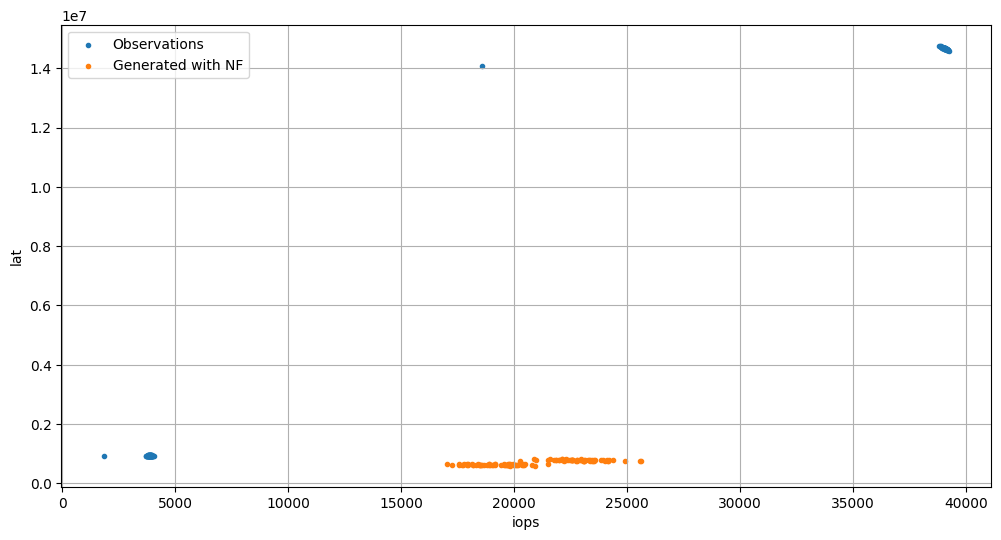

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 8th model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-19-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.001, n_layers=16, n_epochs=150, batch_size=64)

In [ ]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

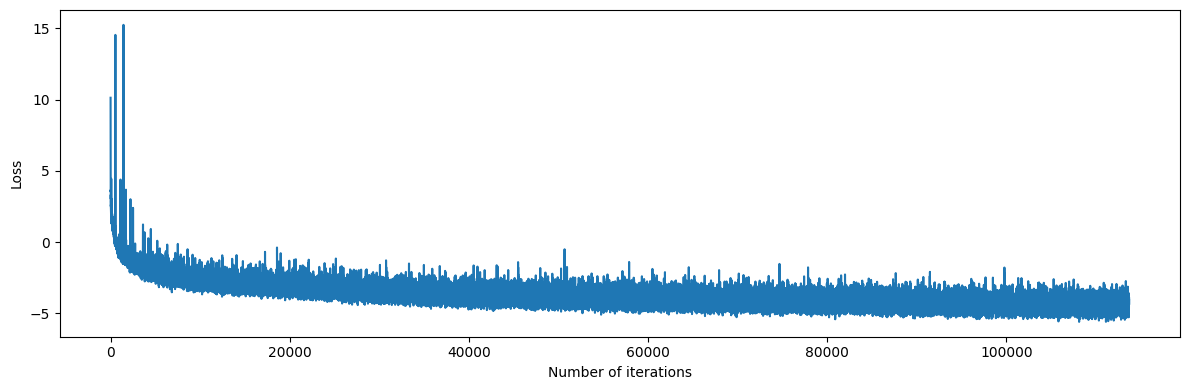

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# samples
y_gen = model.sample(X_test_ss)

In [ ]:
scaler.inverse_transform(y_gen)

array([[1.38303740e+04, 5.66863277e+05],
       [1.24083062e+04, 5.70960391e+05],
       [1.48229181e+04, 5.68330871e+05],
       ...,
       [3.91445824e+04, 1.74392123e+07],
       [3.84528000e+04, 1.75517429e+07],
       [3.85756874e+04, 1.71359713e+07]])

In [ ]:
y_gen_ss = scaler.inverse_transform(y_gen)

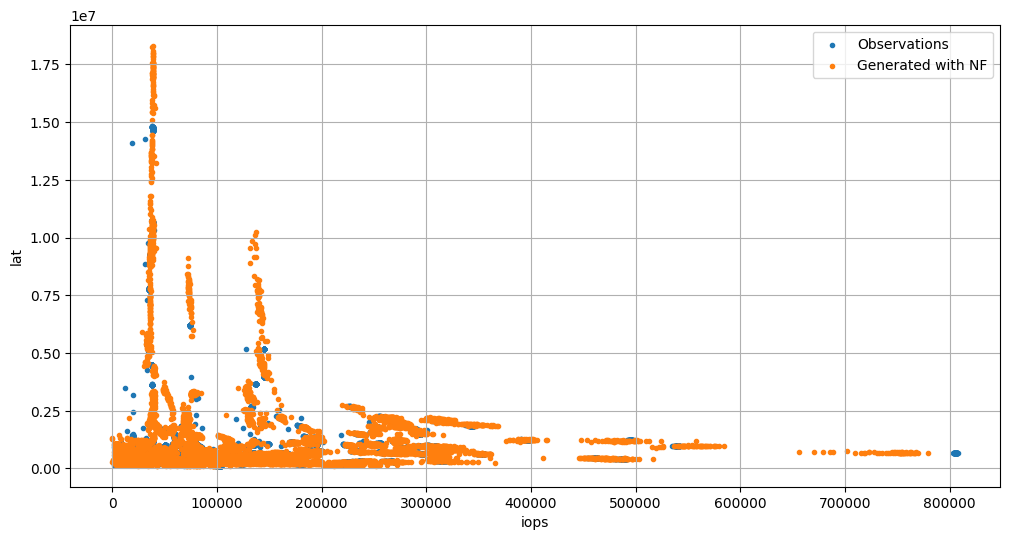

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

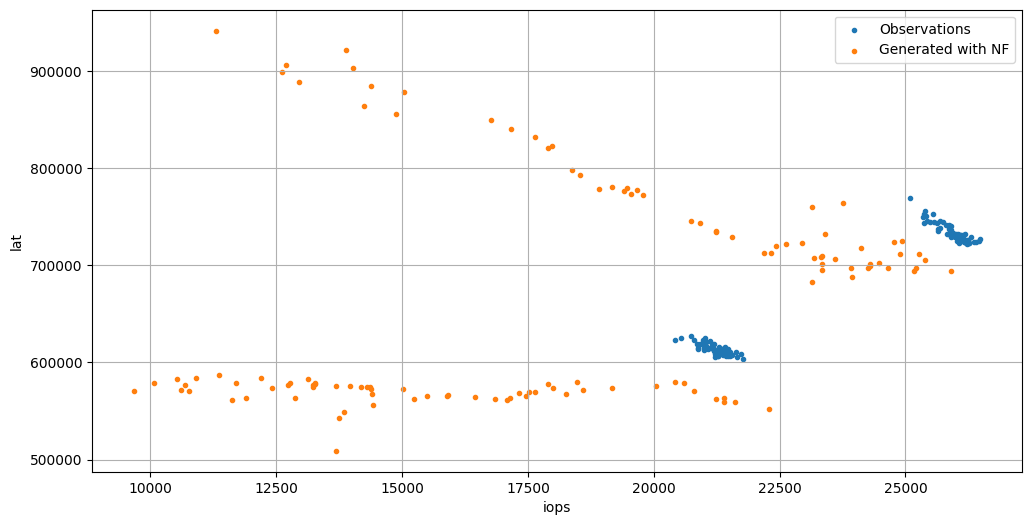

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

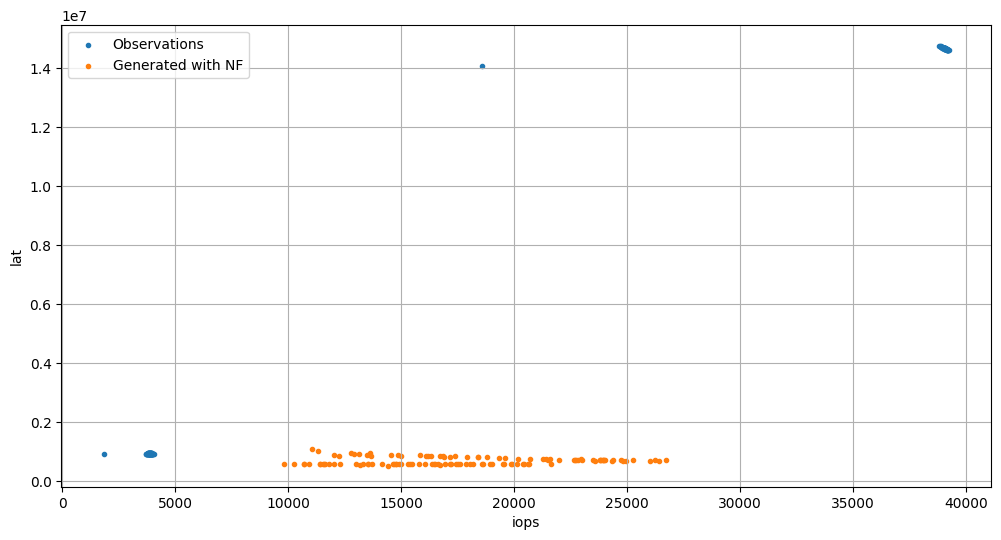

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 9th model

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [26]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [27]:
stscaler = StandardScaler()

In [28]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [29]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.002, n_layers=20, n_epochs=80, batch_size=64)

In [30]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

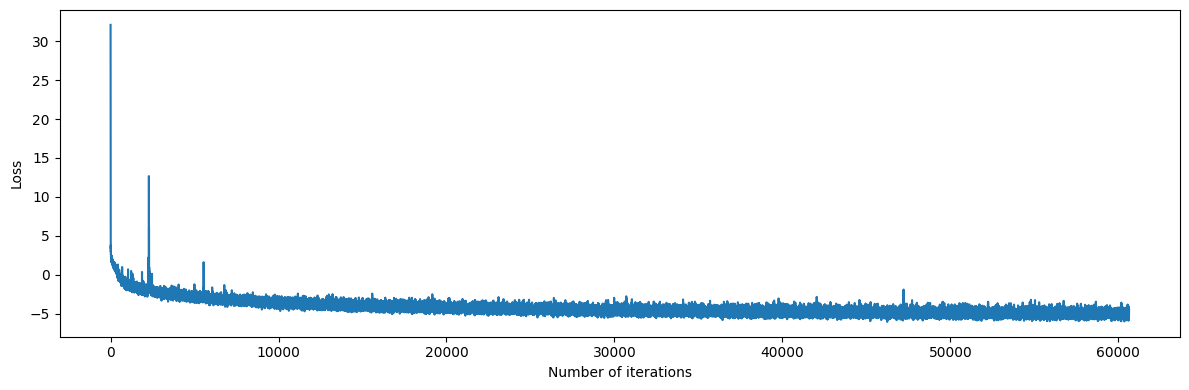

In [31]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [32]:
# samples
y_gen = model.sample(X_test_ss)

In [33]:
scaler.inverse_transform(y_gen)

array([[   17254.69997469,   594924.606092  ],
       [   16940.57448024,   588248.15913508],
       [   19187.50047154,   592849.53829659],
       ...,
       [   37925.45152128, 15566662.98859435],
       [   38051.47792416, 14285023.11057517],
       [   38264.82485644, 13917533.11215894]])

In [34]:
y_gen_ss = scaler.inverse_transform(y_gen)

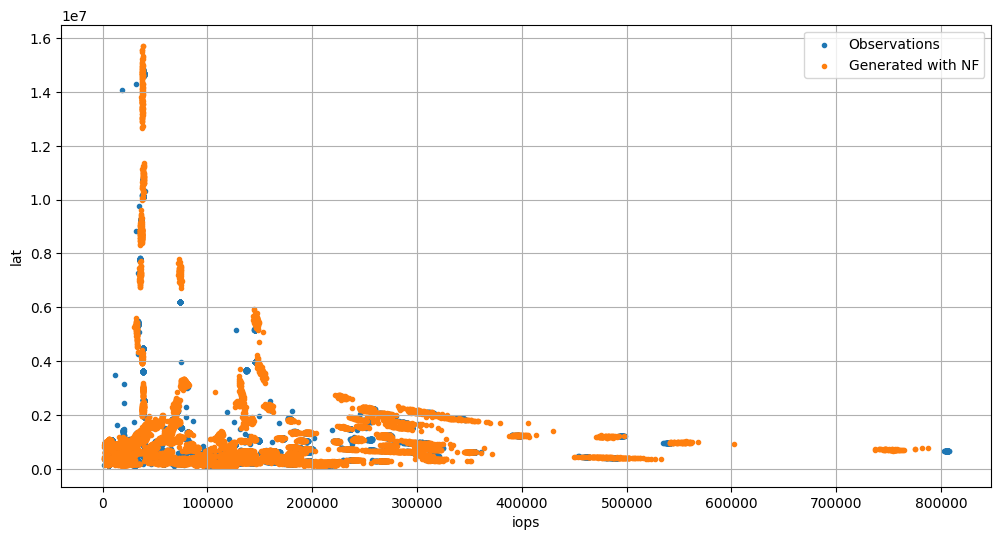

In [35]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [36]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [37]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [38]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [39]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

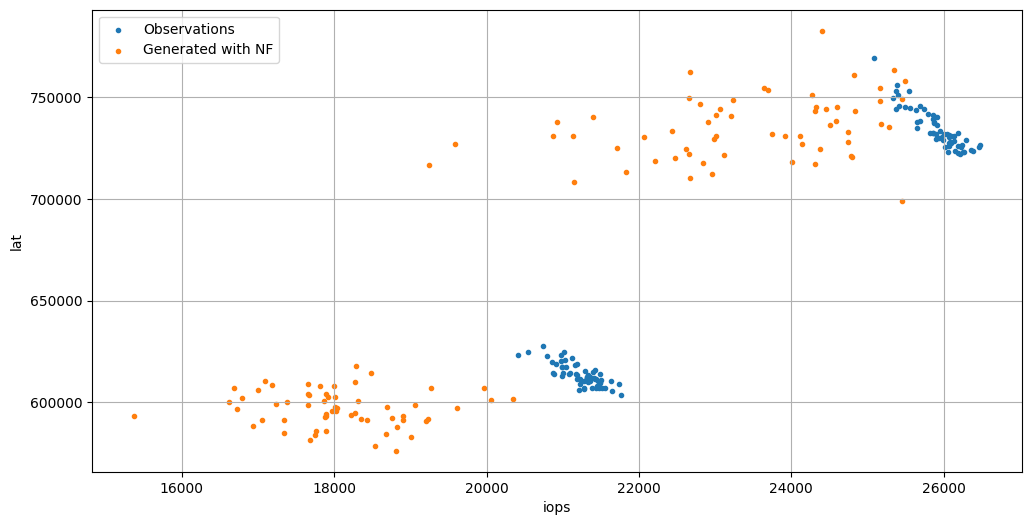

In [40]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [41]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [42]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [43]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [44]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

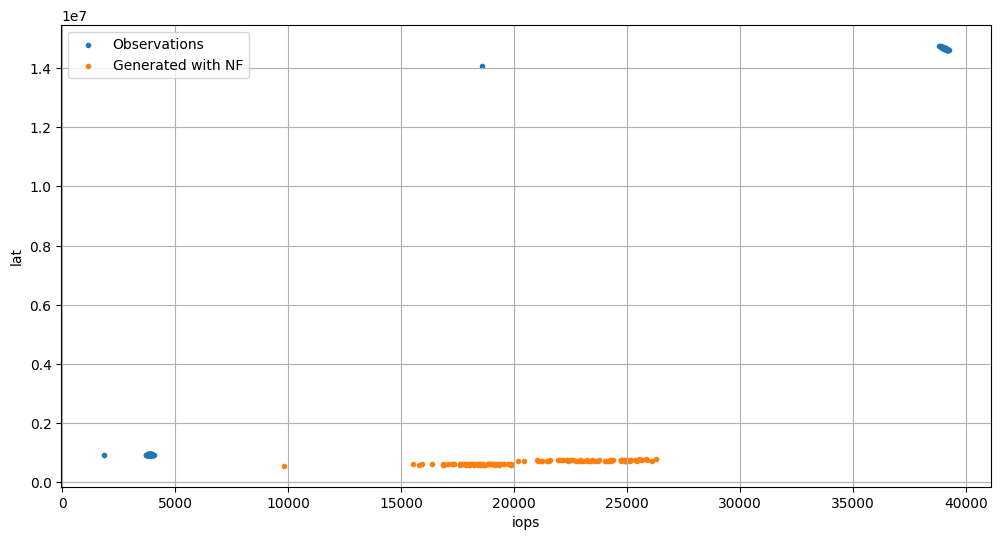

In [45]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## 10th model

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [47]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [48]:
stscaler = StandardScaler()

In [49]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [50]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.002, n_layers=22, n_epochs=100, batch_size=64)

In [51]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

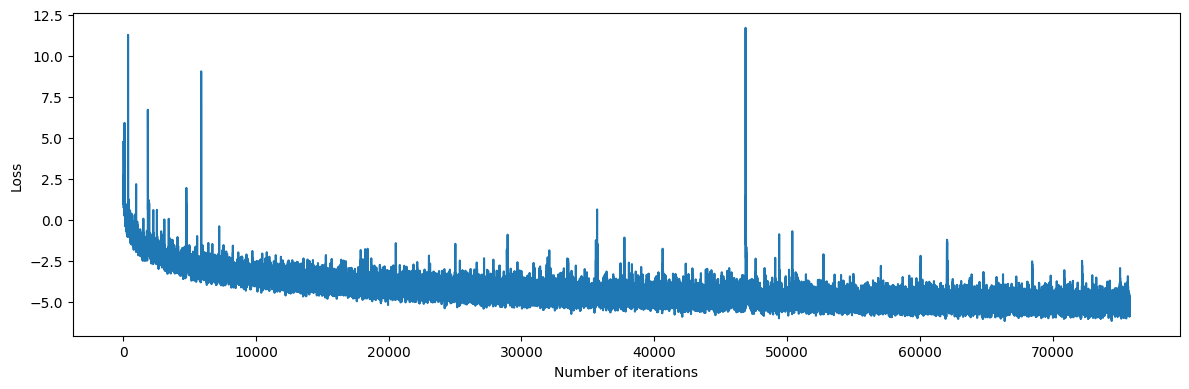

In [52]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [53]:
# samples
y_gen = model.sample(X_test_ss)

In [54]:
scaler.inverse_transform(y_gen)

array([[1.37568754e+04, 6.17464087e+05],
       [1.41949963e+04, 6.11276371e+05],
       [1.30871185e+04, 6.16470582e+05],
       ...,
       [3.76647737e+04, 1.67378984e+07],
       [3.78181840e+04, 1.53227750e+07],
       [3.81688508e+04, 1.54689967e+07]])

In [55]:
y_gen_ss = scaler.inverse_transform(y_gen)

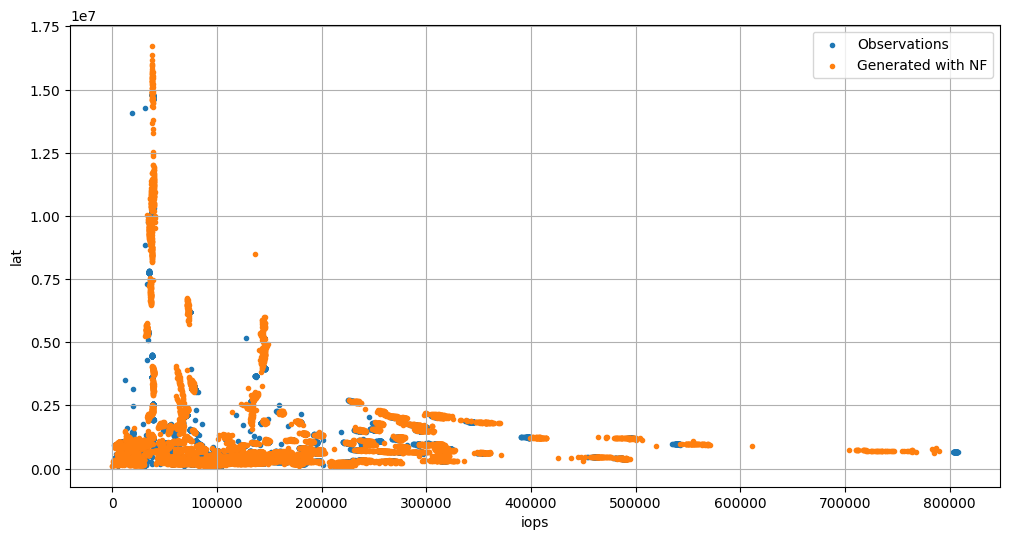

In [56]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [57]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [58]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [59]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [60]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

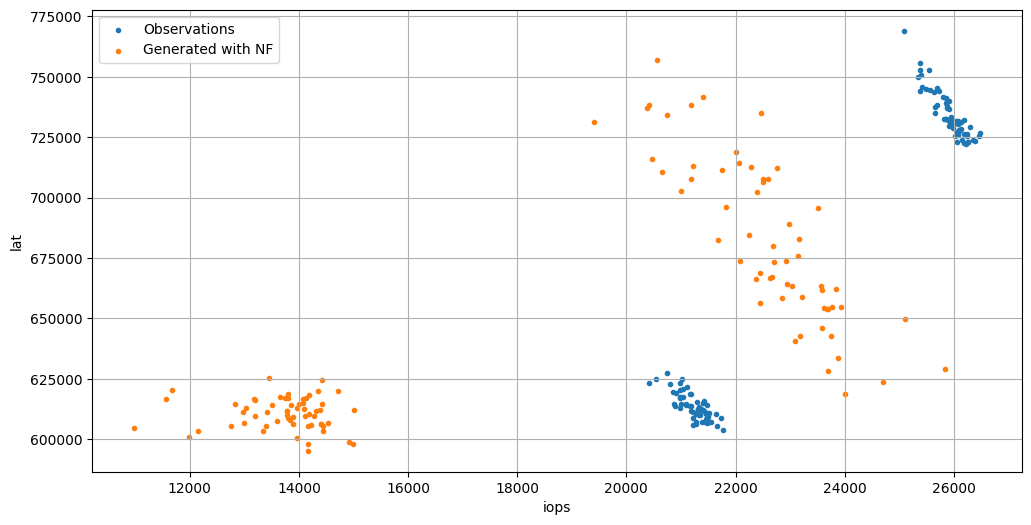

In [61]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [62]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

In [63]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-120657-z13242'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [64]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [65]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

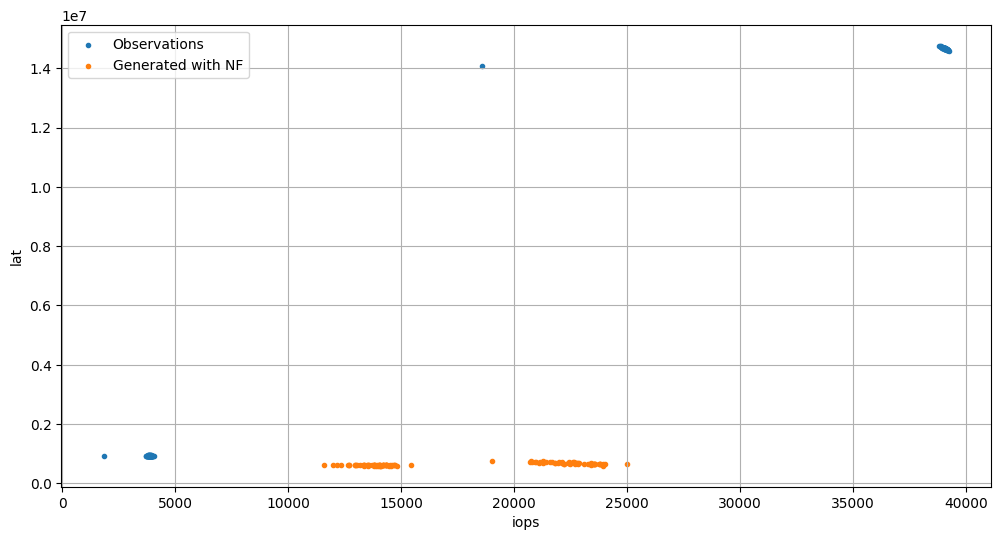

In [66]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Separate models

### Model 1

In [70]:
ids = pd.unique(train[['id']]. values.ravel())

In [71]:
id1 = np.array([np.random.sample() for i in range(len(ids))])

In [72]:
ar1 = []
for i in range(len(ids)):
  if id1[i] <= 0.7:
    ar1.append(ids[i])

In [73]:
train1 = train.loc[train['id'].isin(ar1)]

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [75]:
y_tr_ss = scaler.fit_transform(train1[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-22-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [76]:
stscaler = StandardScaler()

In [77]:
X_tr_ss = stscaler.fit_transform(train1[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [78]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.001, n_layers=18, n_epochs=60, batch_size=64)

In [79]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

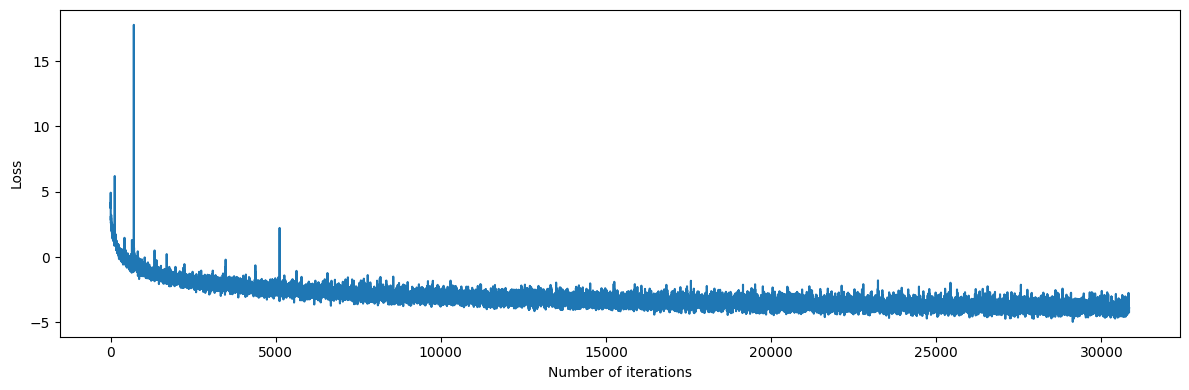

In [80]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [81]:
# samples
y_gen = model.sample(X_test_ss)

In [82]:
scaler.inverse_transform(y_gen)

array([[1.63647025e+04, 5.78956085e+05],
       [1.56044494e+04, 5.82707094e+05],
       [1.45446582e+04, 5.80169456e+05],
       ...,
       [3.91101585e+04, 1.45319189e+07],
       [3.87165454e+04, 1.49245186e+07],
       [3.88918423e+04, 1.48380065e+07]])

In [83]:
y_gen_ss = scaler.inverse_transform(y_gen)

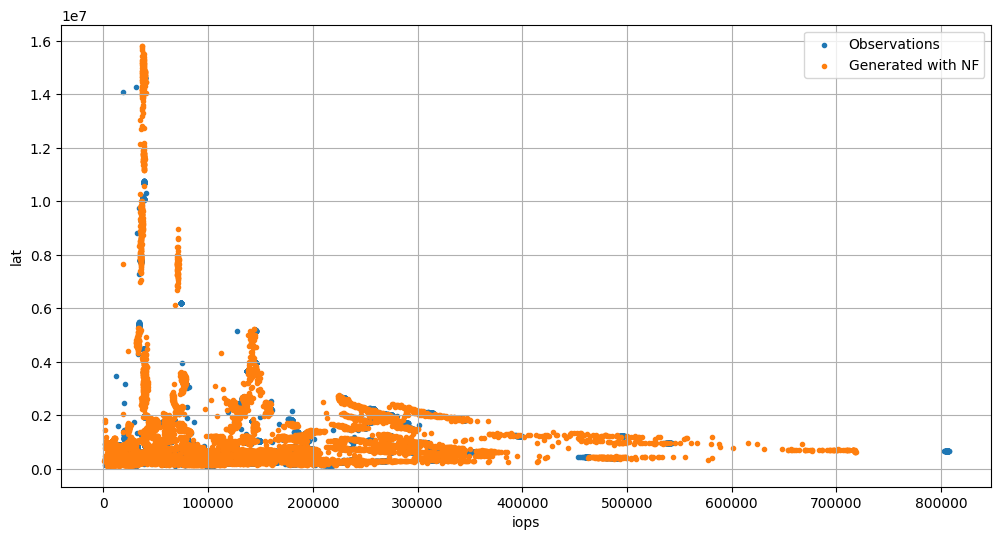

In [84]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

#### 1

In [85]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [86]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [87]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [88]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

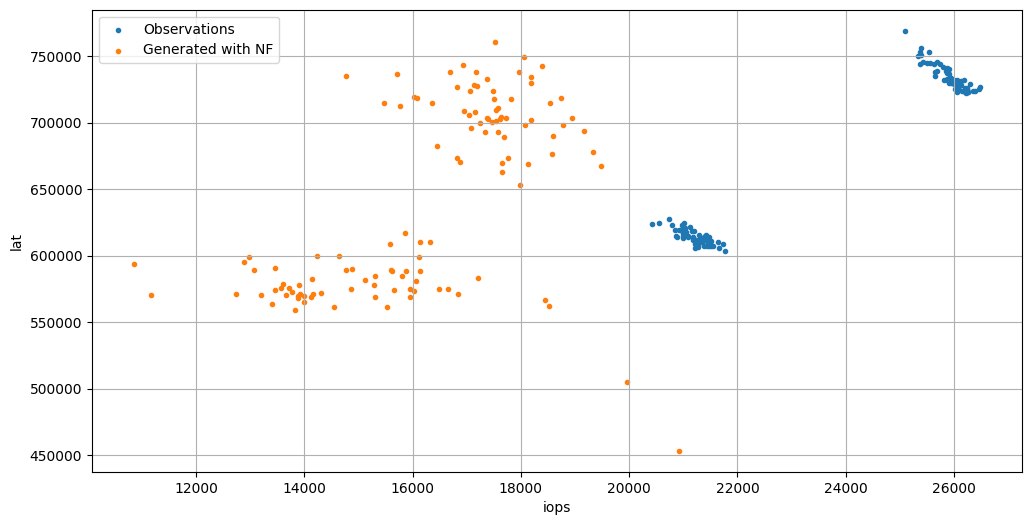

In [89]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### Model 2

In [95]:
ids = pd.unique(train[['id']]. values.ravel())

In [96]:
id2 = np.array([np.random.sample() for i in range(len(ids))])

In [97]:
ar2 = []
for i in range(len(ids)):
  if id2[i] <= 0.7:
    ar2.append(ids[i])

In [98]:
train2 = train.loc[train['id'].isin(ar2)]

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [100]:
y_tr_ss = scaler.fit_transform(train2[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-22-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [101]:
stscaler = StandardScaler()

In [102]:
X_tr_ss = stscaler.fit_transform(train2[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [103]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.001, n_layers=18, n_epochs=60, batch_size=64)

In [104]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

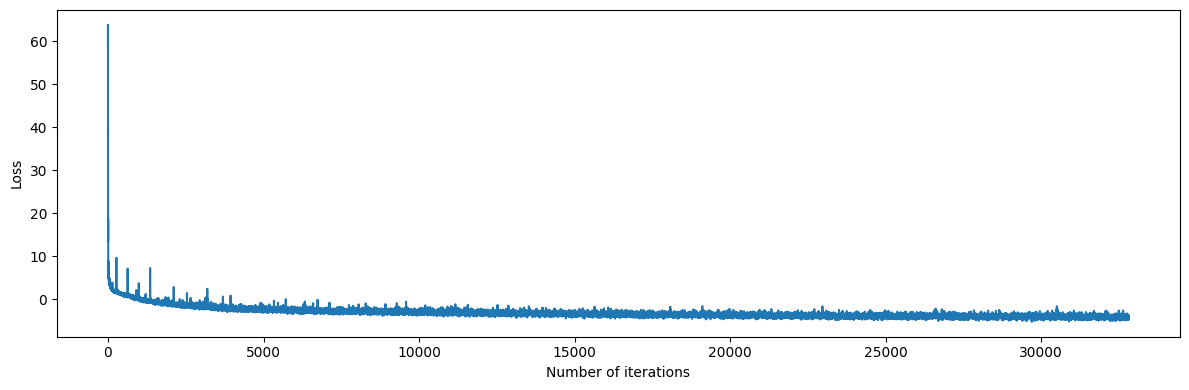

In [105]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [106]:
# samples
y_gen = model.sample(X_test_ss)

In [107]:
scaler.inverse_transform(y_gen)

array([[1.54545644e+04, 6.16389373e+05],
       [1.31025898e+04, 6.14215100e+05],
       [1.15730824e+04, 5.55979125e+05],
       ...,
       [3.84316621e+04, 1.44333946e+07],
       [3.91088232e+04, 1.51456732e+07],
       [3.96715089e+04, 1.47392188e+07]])

In [108]:
y_gen_ss = scaler.inverse_transform(y_gen)

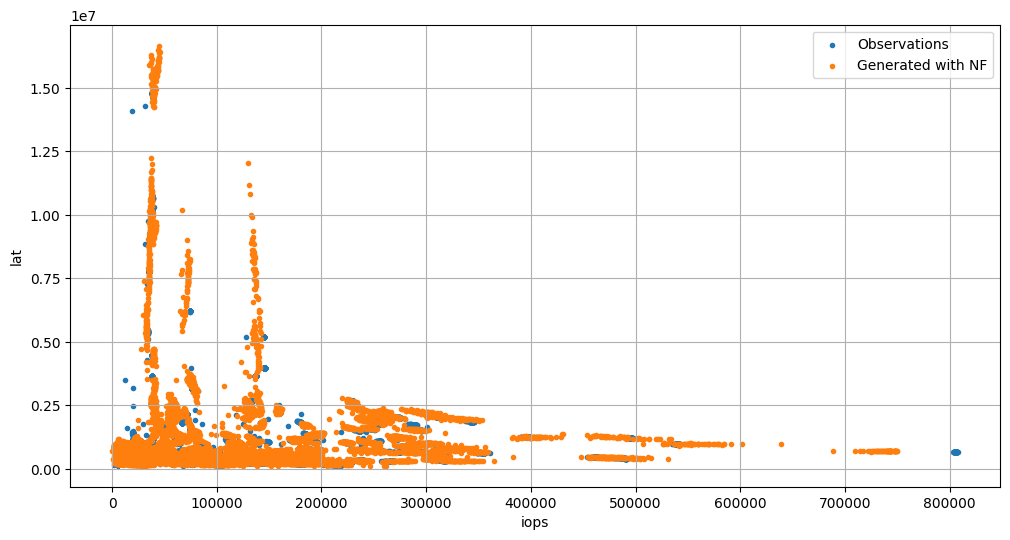

In [109]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

#### 1

In [110]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [111]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [112]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [113]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

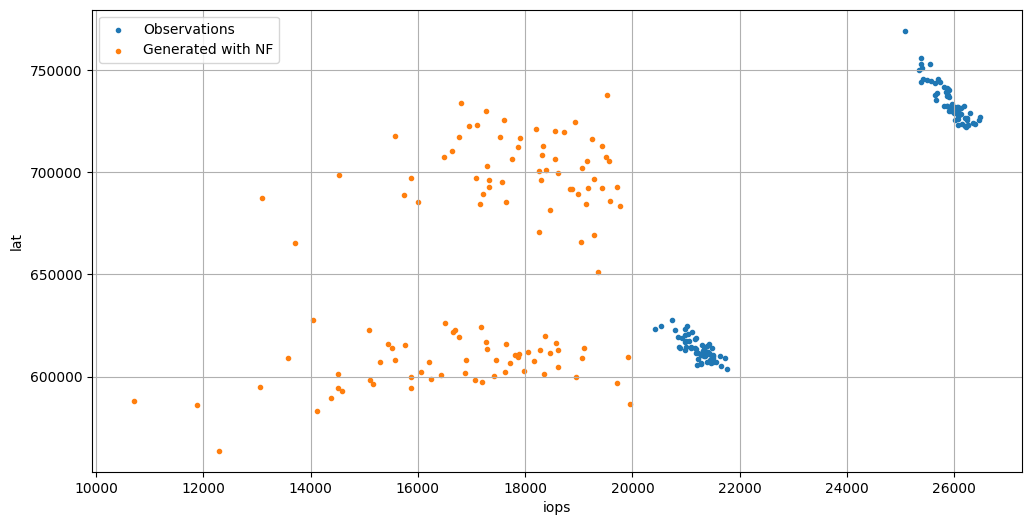

In [114]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### Model 3

In [120]:
ids = pd.unique(train[['id']]. values.ravel())

In [121]:
id3 = np.array([np.random.sample() for i in range(len(ids))])

In [122]:
ar3 = []
for i in range(len(ids)):
  if id3[i] <= 0.7:
    ar3.append(ids[i])

In [123]:
train3 = train.loc[train['id'].isin(ar3)]

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())

In [125]:
y_tr_ss = scaler.fit_transform(train3[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-22-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [126]:
stscaler = StandardScaler()

In [127]:
X_tr_ss = stscaler.fit_transform(train3[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [128]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.001, n_layers=18, n_epochs=60, batch_size=64)

In [129]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

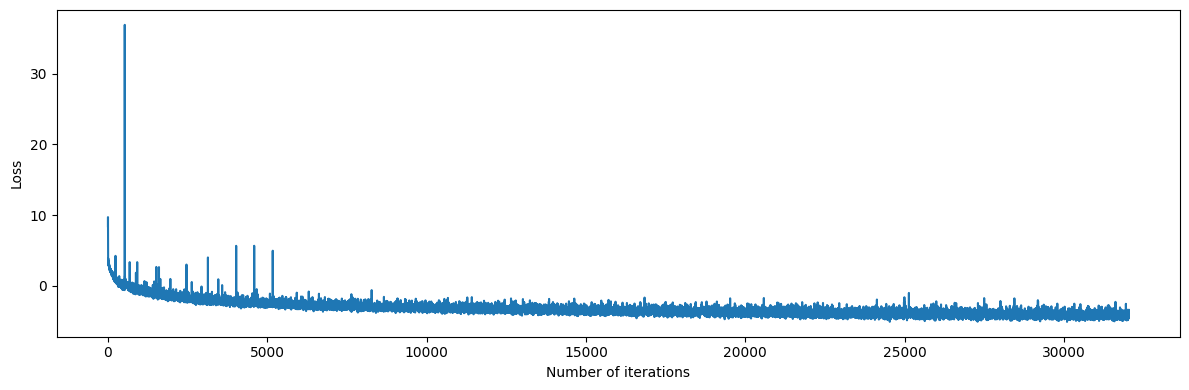

In [130]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [131]:
# samples
y_gen = model.sample(X_test_ss)

In [132]:
scaler.inverse_transform(y_gen)

array([[   19406.56579466,   569188.64736369],
       [   20010.45812892,   580593.84258292],
       [   19748.9806969 ,   574803.1254271 ],
       ...,
       [   38370.09452114, 12910754.80999905],
       [   41490.11357691, 14319970.22593929],
       [   39121.44757277, 12119170.93004813]])

In [133]:
y_gen_ss = scaler.inverse_transform(y_gen)

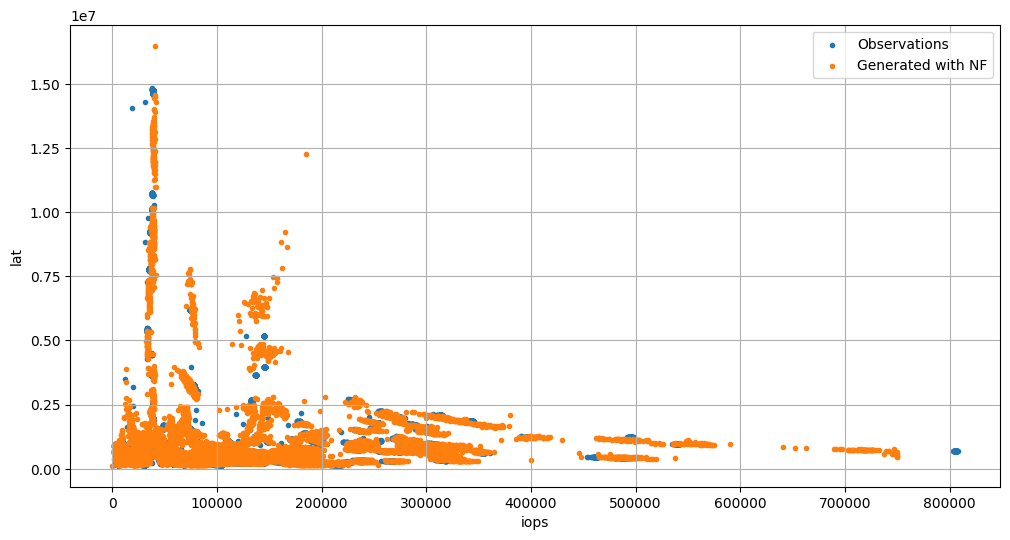

In [134]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

#### 1

In [135]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [136]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [137]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [138]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

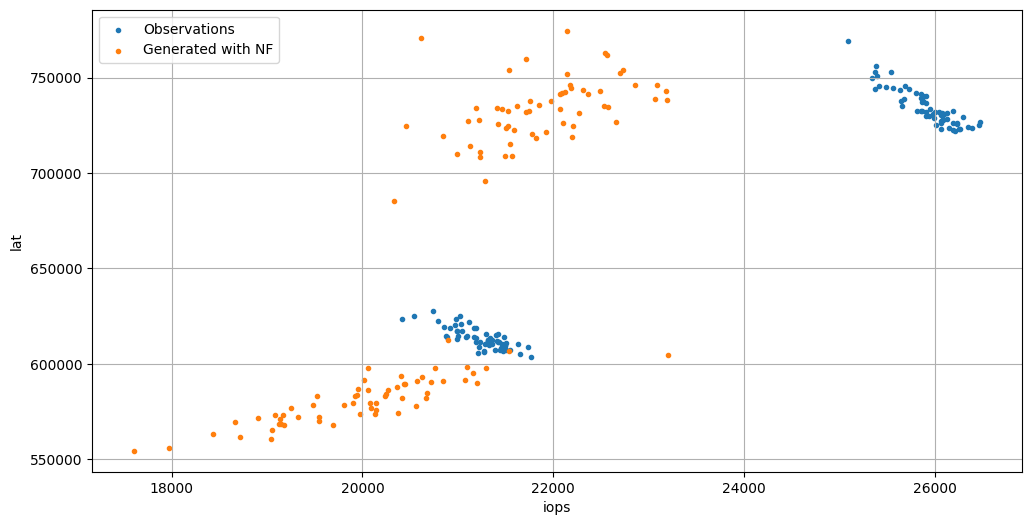

In [139]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()